# Experimental results for adaptive air caution

In [15]:
#import libraries
import numpy as np
import pandas as pd
from os import path, listdir
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [16]:
# set file path
data_dir = path.join('data','scaledCushion_1-2', '31-05-2022')
data_dir_list = listdir(data_dir)
print('Data directory: {}'.format(data_dir))
print('Files in data data directory: {}\n'.format(data_dir_list))

crio_data_dir = path.join(data_dir, 'data_crio')
shimmer_data_dir = path.join(data_dir, 'data_shimmer')
movies_data_dir = path.join(data_dir, 'movies')

# get list of files
crio_dir_list = sorted(listdir(crio_data_dir))
shimmer_dir_list = sorted(listdir(shimmer_data_dir))
movies_dir_list = sorted(listdir(movies_data_dir))
file_names = pd.DataFrame()
file_names['data_crio'] = crio_dir_list
file_names['data_shimmer'] = shimmer_dir_list
file_names['data_movies'] = movies_dir_list
#file_names.sort_values(by = ['data_crio', 'data_shimmer', 'data_movies'] , inplace =True, ignore_index=True)
print('List of files:')
file_names

Data directory: data/scaledCushion_1-2/31-05-2022
Files in data data directory: ['data_crio', 'movies', 'data_shimmer']

List of files:


,data_crio,data_shimmer,data_movies
0,h1500_m10_vc_1.lvm,h1500_m10_vc_1.txt,h1500_m10_vc_1.mp4
1,h1500_m10_vc_2.lvm,h1500_m10_vc_2.txt,h1500_m10_vc_2.mp4
2,h1500_m10_vo_1.lvm,h1500_m10_vo_1.txt,h1500_m10_vo_1.mp4
3,h1500_m10_vo_2.lvm,h1500_m10_vo_2.txt,h1500_m10_vo_2.mp4
4,h1500_m5_vc_1.lvm,h1500_m5_vc_1.txt,h1500_m5_vc_1.mp4
5,h1500_m5_vc_2.lvm,h1500_m5_vc_2.txt,h1500_m5_vc_2.mp4
6,h1500_m5_vo_1.lvm,h1500_m5_vo_1.txt,h1500_m5_vo_1.mp4
7,h1500_m5_vo_2.lvm,h1500_m5_vo_2.txt,h1500_m5_vo_2.mp4
8,h2500_m10_vc_1.lvm,h2500_m10_vc_1.txt,h2500_m10_vc_1.mp4
9,h2500_m10_vc_2.lvm,h2500_m10_vc_2.txt,h2500_m10_vc_2.mp4


## Print file path and experimental data

In [17]:
# load data from c-rio
def load_crio_data(filename):
    crio_data = pd.read_csv(path.join(crio_data_dir, filename), sep='\t', header = None)
    print(np.shape(crio_data))
    crio_data.drop([0, 9], axis = 1, inplace=True)
    crio_data.columns = ['Top chamber pressure', 'Bottom chamber pressure','Air frame pressure',\
                         'Absolute pressure', 'Force 1', 'Force 2',\
                         'Force 3', 'Force 4']
    return crio_data

sample_crio_data = load_crio_data(file_names['data_crio'][0])
sample_crio_data.head()

(5000, 10)


,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Force 1,Force 2,Force 3,Force 4
0,0.361044,-0.369590,163.415335,1006.847816,316.963867,60.443743,101.661236,232.480965
1,0.012146,-0.049425,162.676610,1007.791922,317.123154,60.443743,103.254611,252.186972
2,-0.213612,0.311788,163.251174,1007.094105,318.238159,63.445810,101.501899,298.167656
3,-0.065843,0.488289,164.810704,1005.862662,320.468170,62.813796,101.820574,317.873663
4,0.159914,0.164019,164.318220,1007.422489,317.601013,62.023778,100.864549,324.442332


In [18]:
# load data from shimmer
def load_shimmer_data(filename):
    shimmer_data = pd.read_csv(path.join(shimmer_data_dir, filename), sep='\t')
    return shimmer_data

sample_shimmer_data = load_shimmer_data(file_names['data_shimmer'][0])
sample_shimmer_data.head()

,Timestamp,PC Timestamp,Low Noise Accelerometer X,Low Noise Accelerometer Y,Low Noise Accelerometer Z,Int A12,Int A13,Int A14,Gyroscope X,Gyroscope Y,Gyroscope Z,Wide Range Accelerometer X,Wide Range Accelerometer Y,Wide Range Accelerometer Z
0,224745.026,NaN,-3.565,1.380,9.152,1504.762,1504.029,1510.623,-4.672,-0.550,3.466,-6.278,-0.459,8.038
1,224746.002,NaN,-3.576,1.380,9.141,1504.029,1504.762,1510.623,-4.672,-0.473,3.771,-6.124,-0.459,8.115
2,224746.979,NaN,-3.565,1.391,9.141,1505.495,1504.029,1509.890,-4.672,-0.473,3.649,-6.278,-0.383,7.962
3,224747.955,NaN,-3.576,1.402,9.141,1504.762,1504.029,1509.158,-4.473,-0.489,3.359,-6.354,-0.459,8.115
4,224748.932,NaN,-3.576,1.402,9.141,1504.762,1503.297,1510.623,-4.275,-0.473,3.603,-6.354,-0.536,8.115


## Plot raw data

(5000, 10)


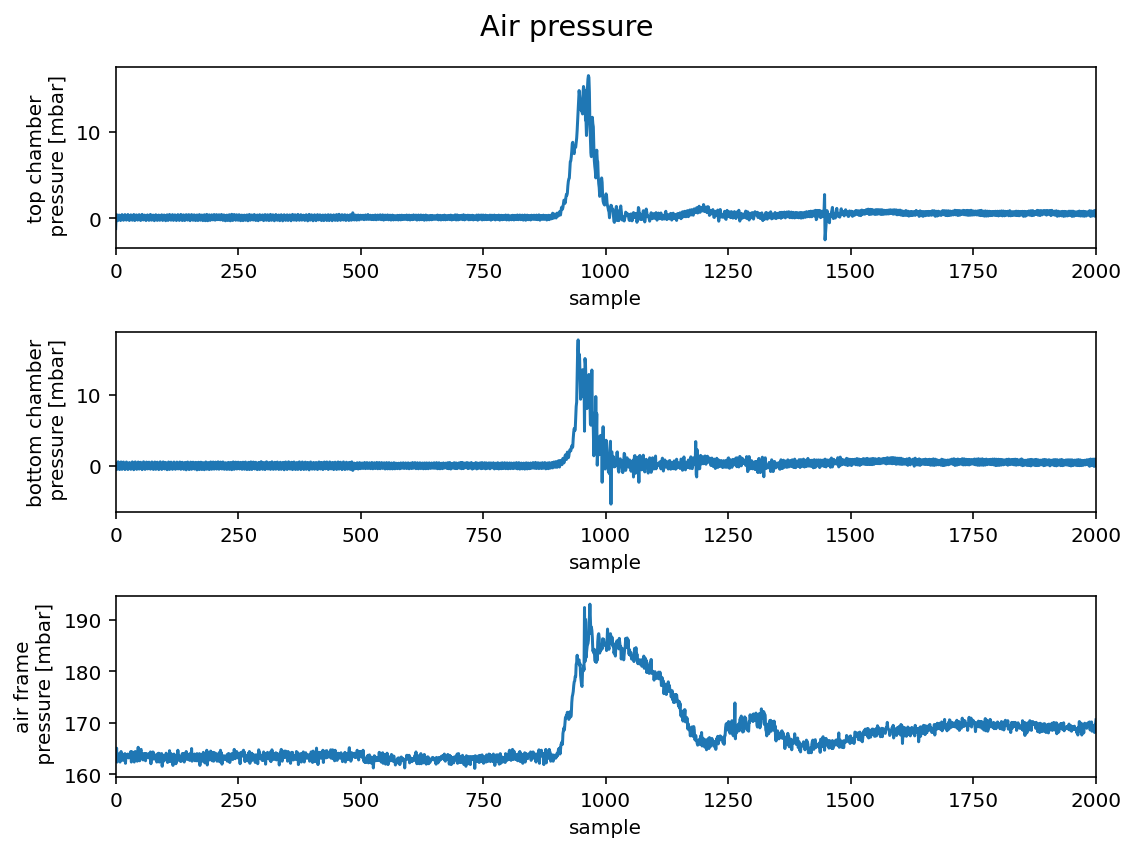

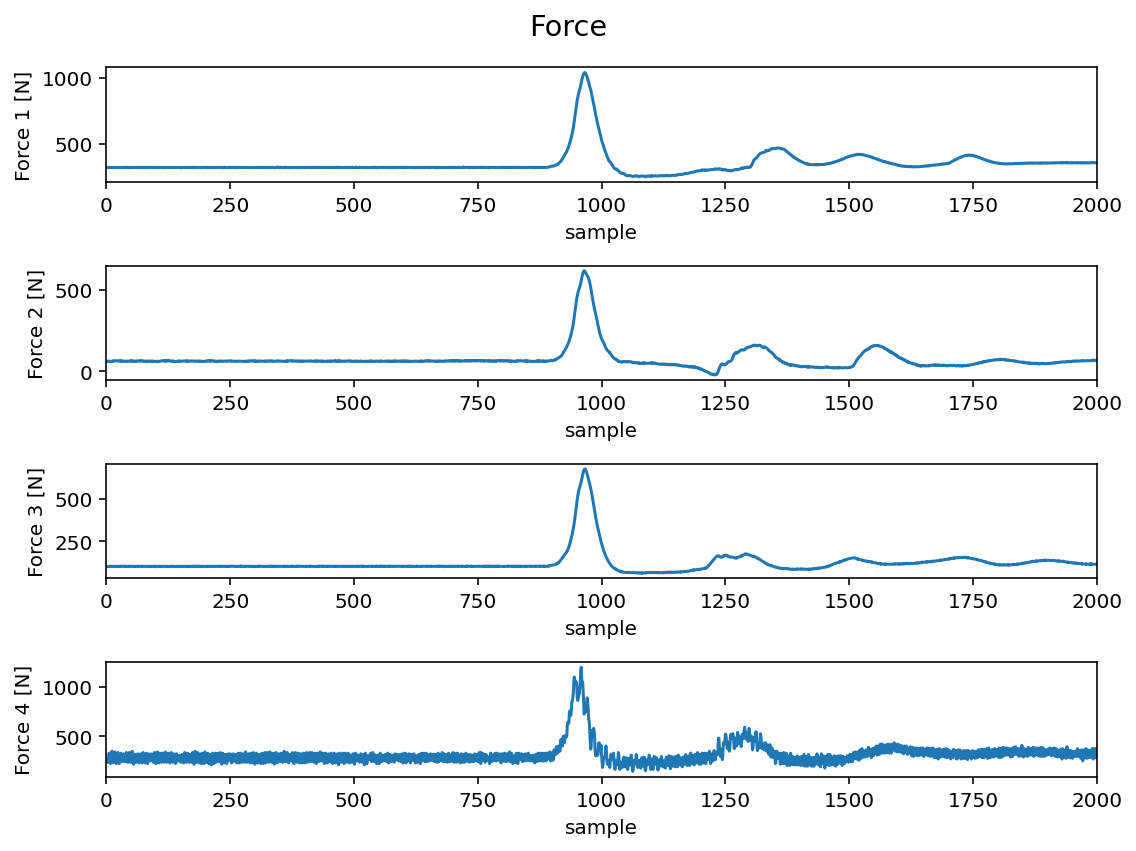

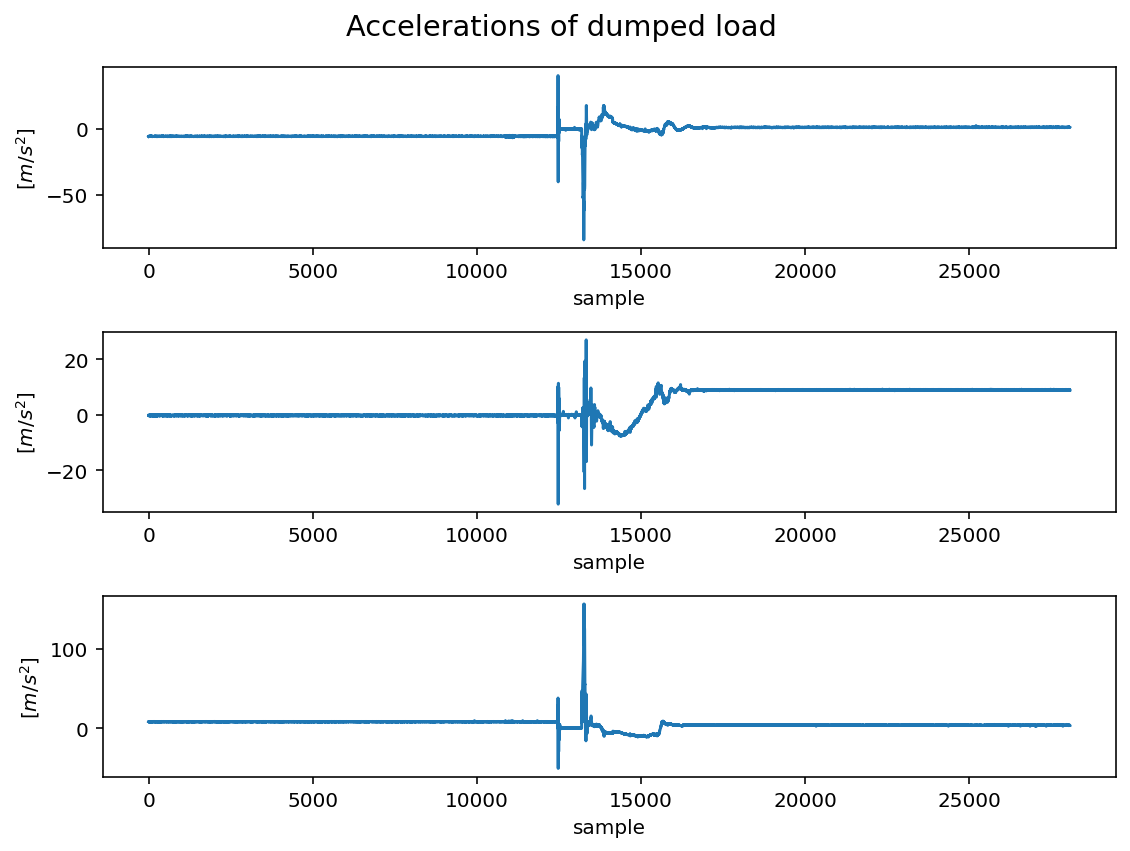

In [110]:
def plot_raw_data(filename):
    # load data
    crio_data = load_crio_data(filename+'.lvm')
    shimmer_data = load_shimmer_data(filename+'.txt')
    
    # plot pressure
    fig1, axs1 = plt.subplots(3, 1, figsize=(8,6))
    axs1[0].plot(crio_data['Top chamber pressure'])
    axs1[1].plot(crio_data['Bottom chamber pressure'])
    axs1[2].plot(crio_data['Air frame pressure'])
    for i in range(3):
        axs1[i].set_xlim(0, 2000)
        axs1[i].set_xlabel('sample')    
    axs1[0].set_ylabel('top chamber\n pressure [mbar]')
    axs1[1].set_ylabel('bottom chamber\n pressure [mbar]')
    axs1[2].set_ylabel('air frame\n pressure [mbar]')
    fig1.suptitle('Air pressure', fontsize='x-large')
    fig1.tight_layout()
    plt.show()
    
    # plot forces
    fig2, axs2 = plt.subplots(4, 1, figsize=(8,6))
    axs2[0].plot(crio_data['Force 1'])
    axs2[1].plot(crio_data['Force 2'])
    axs2[2].plot(crio_data['Force 3'])
    axs2[3].plot(crio_data['Force 4'])
    for i in range(4):
        axs2[i].set_xlim(0, 2000)
        axs2[i].set_xlabel('sample')
        axs2[i].set_ylabel('Force {} [N]'.format(i+1))
    fig2.suptitle('Force', fontsize='x-large')
    fig2.tight_layout()
    plt.show()
    
    # plot acceleration
    fig3, axs3 = plt.subplots(3, 1, figsize=(8,6))
    axs3[0].plot(shimmer_data['Wide Range Accelerometer X'])
    axs3[1].plot(shimmer_data['Wide Range Accelerometer Y'])
    axs3[2].plot(shimmer_data['Wide Range Accelerometer Z'])
    for i in range(3):
        axis = ['X', 'Y', 'Z']
        #axs1[i].set_xlim(0, 2000)
        axs3[i].set_xlabel('sample')    
        axs3[i].set_ylabel(r'$[m/s^2]$')
    fig3.suptitle('Accelerations of dumped load', fontsize='x-large')
    fig3.tight_layout()
    plt.show()
    
    pass

plot_raw_data('h3500_m10_vc_1')

In [6]:
data_range = 3000 # select number of samples to be processed

def sync_force(plate_reaction_force, wireless_accel_force, data_range = 2000):
    plate_peak_index = plate_reaction_force
    #wireless_accel_peak_index =  
    return synchronized_vect

# proces and plot pressures
def plot_data(crio_filename, shimmer_filename):
    
    crio_data = load_crio_data(crio_filename)
    shimmer_data = load_shimmer_data(shimmer_filename)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    chamber_pressure = crio_data.iloc[:data_range, 0:2].rolling(30).mean()
    chamber_pressure.plot.line(title = 'Pressure', ylabel = 'pressure [mbar]',\
                                         ax=axes[0])
    air_frame_pressure = crio_data.iloc[:data_range, 2:3].rolling(30).mean()
    air_frame_pressure.plot.line(xlabel = 'time [ms]', ylabel = 'pressure [mbar]',\
                                         ax=axes[1])
    plt.show()
    
    # proces and plot forces 
    fig, axes = plt.subplots(nrows=2, ncols=1)
    impact_plate_reaction_force = crio_data.iloc[:data_range, 4:-2].sum(axis=1)
    force_offset = impact_plate_reaction_force.iloc[:500].mean()
    impact_plate_reaction_force = impact_plate_reaction_force.subtract(force_offset)
    impact_plate_reaction_force.plot.line(ylabel = 'impact plate\n reaction force [N]', ax=axes[0])
    shimmer_force = np.sqrt(np.sum(np.power(shimmer_data.iloc[:,-3:], 2), axis=1))
    shimmer_force = shimmer_force.rolling(30).mean()
    shimmer_force.plot.line(xlabel = 'time [ms]', ylabel = 'wireless accelerometer\n force [N]', ax=axes[1])
    plt.show()

(5000, 10)


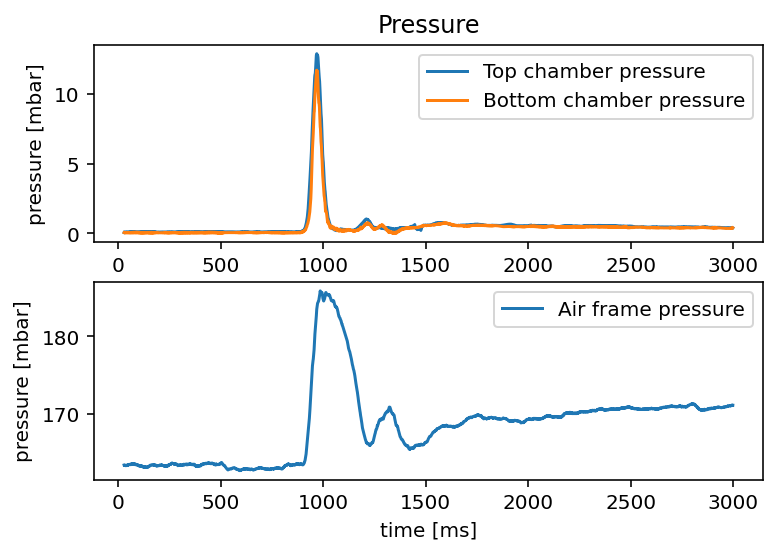

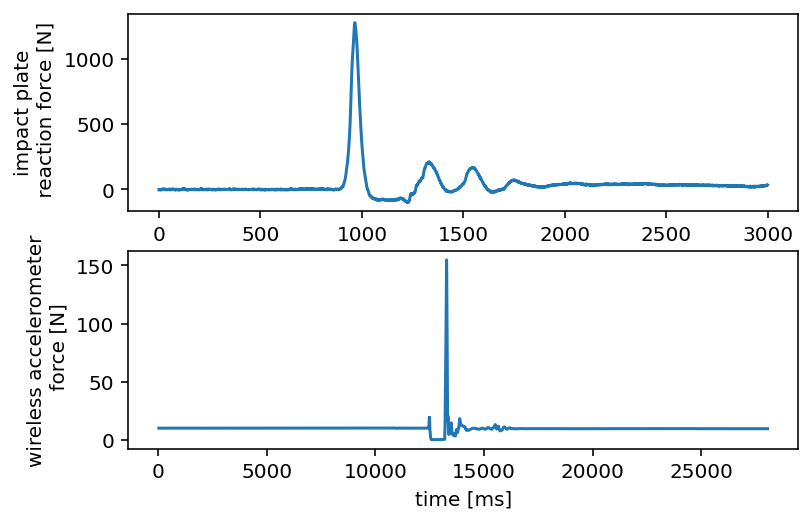

In [10]:
plot_data(file_names['data_crio'][16], file_names['data_shimmer'][16])

## Plot raw data 

In [12]:
# play movie
movie_title = file_names['data_movies'][16]
movie_path = path.join(data_dir, 'movies', movie_title)
Video(movie_path, width=600, height=480)

In [9]:
# 1. ta sama wysokość 
# 1. różne masy
# 1. otwarty zamknięty